In [1]:
import numpy as np
import pandas as pd
from lptools.utils import Adapter, Runner
from lptools.clients import Client
from lptools.instruments import UniPool, Bond, Portfolio, Position, Cash, Perpetual
from lptools.instruments import Holder, PerpetHedger
from copy import copy
import matplotlib.pyplot as plt
from lptools.solver import Solver

Skipping dotenv


In [2]:
zcurve = pd.read_csv('zcyc_rates.csv', index_col=0, parse_dates=True, infer_datetime_format=True, na_filter=False,)

adapter = Adapter(
        pool_id="0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640",
        symbol="ETHUSDT",
        zcurve=zcurve,
        base_interval='1d'
)

# response = adapter(300)
#response.to_csv('saved_response.csv')

In [3]:
response = pd.read_csv('saved_response.csv', index_col=0, infer_datetime_format=True)
response.index = pd.to_datetime(response.index)

In [4]:
response[response.index < '2021-12-03'].tail()

,fundingRate,Open,Volume,date,feesUSD,liquidity,sqrtPrice,token0Price,token1Price,tvlUSD,volumeUSD,mark,risk_free_rate
2021-11-26,0.000632,4528.20,2657050.069,1.637885e+09,717110.610623,2.178692e+19,1.246242e+33,4041.612472,0.000247,2.292489e+08,1.434221e+09,4525.911728,8.08
2021-11-27,0.000300,4040.66,1008009.177,1.637971e+09,312449.057898,2.165517e+19,1.237733e+33,4097.371402,0.000244,2.312423e+08,6.248981e+08,4041.870000,8.08
2021-11-28,0.000300,4095.33,1512818.390,1.638058e+09,437245.243253,2.791476e+19,1.208955e+33,4294.761309,0.000233,2.411140e+08,8.744905e+08,4095.855379,8.08
2021-11-29,0.000300,4297.01,1432921.208,1.638144e+09,386101.218819,3.182996e+19,1.188192e+33,4446.166582,0.000225,2.559034e+08,7.722024e+08,4296.600000,7.81
2021-11-30,0.000392,4445.09,2573876.207,1.638230e+09,661288.243740,1.938722e+19,1.163808e+33,4634.430105,0.000216,2.630019e+08,1.322576e+09,4444.687798,7.86


In [5]:
solver = Solver(response)
results = solver.solve(t = 20,
             delta1=.1, q1=.95,
             delta2=.05, q2=.95,
             verbose=True, maxiter=10)

print(results)

differential_evolution step 1: f(x)= -140.049
differential_evolution step 2: f(x)= -140.049
differential_evolution step 3: f(x)= -140.049
differential_evolution step 4: f(x)= -140.049
differential_evolution step 5: f(x)= -148.936
differential_evolution step 6: f(x)= -148.936
differential_evolution step 7: f(x)= -148.936
differential_evolution step 8: f(x)= -148.936
differential_evolution step 9: f(x)= -148.936
differential_evolution step 10: f(x)= -148.936
           constr: [array([0.]), array([0.05061473]), array([0.])]
 constr_violation: 0.050614729012087606
              fun: -148.93577799025343
            maxcv: 0.050614729012087606
          message: 'The solution does not satisfy the constraints, MAXCV = '
             nfev: 385
              nit: 10
          success: False
                x: array([0.87157146, 1.41129071])


In [6]:
#pl, pu = map(lambda x: x*init_state.token0Price, results.x)
pl, pu =  .87, 1.41

1. Hold

In [7]:
def holder_portfolio(init_state):
    perpetual = Position(tag='perpet', instrument=Perpetual())
    bond = Position(tag='bond', instrument=Bond(init_state))

    positions = [perpetual, bond]
    balancer = Holder(positions, initial_amounts=[1 / init_state.token0Price, -1])
    return Portfolio(balancer, positions=positions)

2. Passive pool

In [8]:
def passive_pool_portfolio(init_state):
    price_lower, price_upper = init_state.token0Price*pl, init_state.token0Price*pu
    pool = Position(tag='pool', instrument=UniPool(init_state , price_lower, price_upper, fees=.005))
    bond = Position(tag='bond', instrument=Bond(init_state))


    positions = [pool, bond]
    balancer = Holder(positions, initial_amounts=[1,-1])
    return Portfolio(balancer, positions=positions)

3. Hedging

In [9]:
def hedged_pool_portfolio(init_state):
    price_lower, price_upper = init_state.token0Price*pl, init_state.token0Price*pu
    pool = Position(tag='pool', instrument=UniPool(init_state , price_lower, price_upper, fees=.005))
    bond = Position(tag='bond', instrument=Bond(init_state))
    perpetual = Position(tag='perpet', instrument=Perpetual(), transaction_fees=4e-4)

    positions = [pool, perpetual, bond]

    delta =  pool.instrument.L * (1 / init_state.token0Price**.5 - price_upper**(-.5))
    
    balancer = PerpetHedger(
        positions,
        initial_amounts=[1, - delta, delta * init_state.token0Price - 1 ],
        rebalancing_interval= 1
    )
    portfolio_hedged = Portfolio(balancer, positions)
    return Portfolio(balancer, positions)

In [10]:
def make_runner(data):
    init_state = data.iloc[0]
    portfolios = list(map(lambda pf: pf(init_state), [holder_portfolio, passive_pool_portfolio,hedged_pool_portfolio]))
    return Runner(data, portfolios)

In [11]:
runner = make_runner(response)
runner.run()

In [12]:
runner.summary

,total_value,discounted_value,min_value
portfolio 0,0.212429,0.203489,-0.529585
portfolio 1,0.076964,0.073380,-0.508575
portfolio 2,0.287844,0.282369,-0.182018


In [12]:
runner.logs(2)

,pool_DV,pool_amount,pool_present_value,perpet_DV,perpet_amount,perpet_present_value,bond_DV,bond_amount,bond_present_value,cumulative_payments,in_cash,payments,transaction_costs,total_value
0,1.000018,1,1.000018,3528.74,-0.000203,-0.717743,1.000000,-0.288875,-0.288915,-0.006575,-0.006576,0.006600,-0.013176,-0.013216
1,0.997441,1,0.997441,3493.17,-0.000206,-0.719649,1.000139,-0.288875,-0.288956,0.002560,0.002562,0.009142,-0.000004,-0.008603
2,1.064042,1,1.064042,3480.98,-0.000129,-0.447453,1.000279,-0.288875,-0.288996,-0.267118,-0.267231,-0.269685,-0.000108,0.060362
3,1.067210,1,1.067210,3914.95,-0.000124,-0.485815,1.000418,-0.288875,-0.289036,-0.284537,-0.284659,-0.017421,-0.000007,0.007700
4,1.074217,1,1.074217,3927.83,-0.000114,-0.447015,1.000558,-0.288875,-0.289077,-0.324923,-0.325074,-0.040398,-0.000016,0.013052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,1.082094,1,1.082094,4528.20,-0.000101,-0.458864,1.028853,-0.288875,-0.297252,-0.076803,-0.084716,0.336298,-0.000135,0.241263
205,1.087485,1,1.087485,4040.66,-0.000092,-0.372003,1.028997,-0.288875,-0.297293,-0.112919,-0.122187,-0.037456,-0.000015,0.296002
206,1.102527,1,1.102527,4095.33,-0.000061,-0.248640,1.029140,-0.288875,-0.297334,-0.236697,-0.250634,-0.128396,-0.000051,0.305918
207,1.109992,1,1.109992,4297.01,-0.000038,-0.163689,1.029284,-0.288875,-0.297376,-0.330377,-0.347869,-0.097196,-0.000039,0.301058


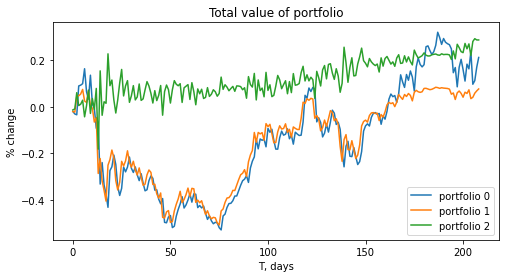

In [13]:
runner.plot_tv()

529.092303526571


<AxesSubplot:>

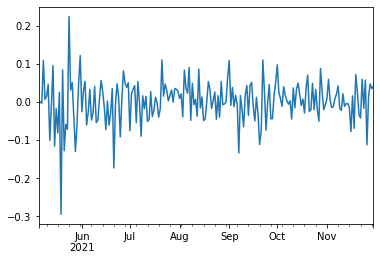

In [14]:
print(response.token0Price.diff().max())
np.log(response.token0Price).diff().plot()

In [15]:
response_first_half = response[response.index < '2021-08-01']
response_second_half = response[response.index > '2021-08-01']


In [16]:
first_half =  make_runner(response_first_half)
first_half.run()
first_half.summary

,total_value,discounted_value,min_value
portfolio 0,-0.337551,-0.333249,-0.529585
portfolio 1,-0.292286,-0.288486,-0.508575
portfolio 2,0.087075,0.090053,-0.182018


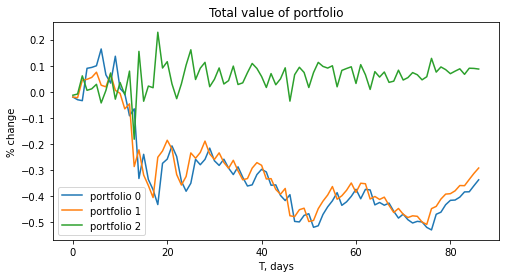

In [17]:
first_half.plot_tv()

In [18]:
second_half = make_runner(response_second_half)
second_half.run()
second_half.summary

,total_value,discounted_value,min_value
portfolio 0,0.662756,0.646941,-0.058915
portfolio 1,0.118813,0.116270,-0.019891
portfolio 2,0.186010,0.169841,-0.013033


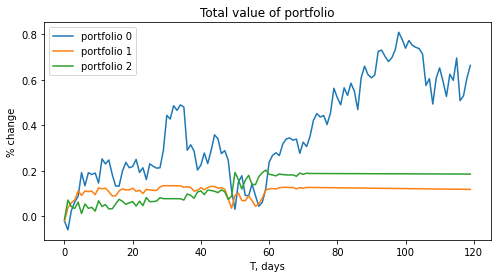

In [19]:
second_half.plot_tv()